In [ ]:
!pip uninstall opencv-python-headless==4.5.3.56 --yes


In [ ]:
# WandB – Install the W&B library
!pip install wandb -q
!pip install opencv-python==4.1.2.30
!pip install imageio
!pip install onnxruntime
!pip install keras2onnx
!pip install tf2onnx
!pip install pyyaml h5py


In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

import wandb
from wandb.keras import WandbCallback
wandb.login()

import tf2onnx
import onnx

import imageio, glob, cv2
import matplotlib.pyplot as plt
%matplotlib inline

wandb: Currently logged in as: cocaint (use `wandb login --relogin` to force relogin)


In [7]:
(train_images, train_labels),(test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Plot head of dataset

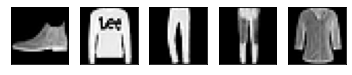

In [8]:
# summarize loaded dataset
# plot first few images
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# Save images for API test

In [9]:
images_to_save = test_images[:5]
labels_to_save = test_labels[:5]

In [10]:
for i in range(len(images_to_save)):
    plt.imsave('images/image_' + str(i) + '.png', images_to_save[i], cmap = 'gray')


# Remove saved images from test

In [11]:
test_images = test_images[5:]
test_labels = test_labels[5:]

# Prepare data for model

In [12]:
# Reshape and normalize images.
train_images_re = np.expand_dims(train_images, axis=3) / 255.0
test_images_re = np.expand_dims(test_images, axis=3) / 255.0

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

classes = np.unique(train_labels)
input_shape = train_images_re[0].shape

print(classes)
print(input_shape)


[0 1 2 3 4 5 6 7 8 9]
(28, 28, 1)


# Images and Lables

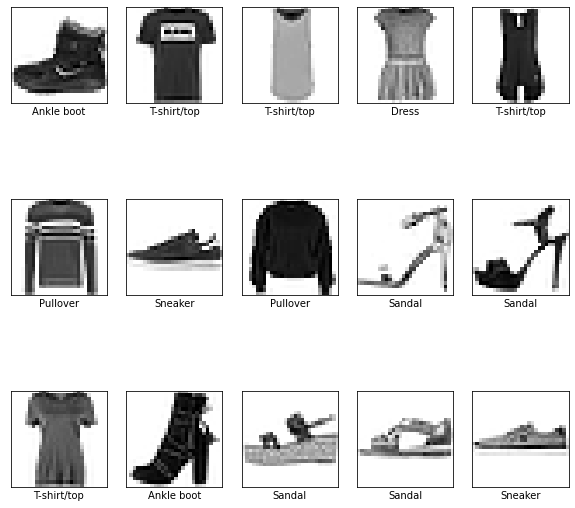

In [15]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images_re[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Set W&B

In [19]:
# Initilize a new wandb run
wandb.init(entity="cocaint", project="AICourseFashioMnist-AviAndMichael")

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = 0.05
config.epochs = 25
config.img_width=28
config.img_height=28
config.num_classes = 10
config.batch_size = 256
config.validation_size = 5000
config.weight_decay = 0.0005
config.activation = 'relu'
config.optimizer = 'Adam'
config.seed = 10

# CreateModels

In [21]:
def createModel(input_shape, num_classes):
    model = Sequential([keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes)])
    return model

def createAnotherModel(input_shape, num_classes):
    model = Sequential([keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes)])
    return model
    

In [22]:
model = createAnotherModel(input_shape, len(classes))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



# Train model

In [25]:
%%wandb
history = model.fit(
    train_images_re,                 
    train_labels, 
    epochs=config.epochs, 
    steps_per_epoch=len(train_images_re) / 32,
    shuffle=True,
    validation_data=(test_images_re, test_labels),
    verbose = 0,
    callbacks=[
        WandbCallback(
            data_type="image",
            validation_data=(test_images_re, test_labels),
            labels=classes
        ),
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ])

wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


In [33]:
test_loss, test_acc = model.evaluate(test_images_re,  test_labels, verbose=2)

313/313 - 7s - loss: 0.2138 - accuracy: 0.9281


# PLOT history

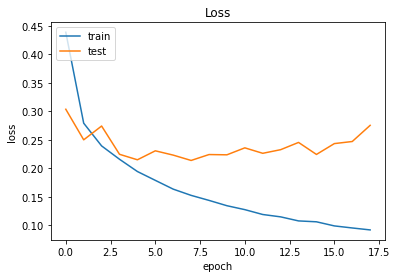

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save model to .onnx format

In [27]:

onnx_model, _ = tf2onnx.convert.from_keras(model,
                                           #input_sig,
                                           opset=13)

onnx.save(onnx_model, 'models/model.onnx')

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [28]:
model.save('models/single_run_model.h5')

In [29]:
model1 = keras.models.load_model('models/single_run_model.h5')
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0

# save wandb model

In [40]:
api = wandb.Api()

sweep = api.sweep("cocaint/AICourseFashioMnist-AviAndMichael/dashing-star-1")
runs = sorted(
    sweep.runs,
        key=lambda run: run.summary.get("val_acc", 0), 
    reverse=True
)
val_acc = runs[0].summary.get("val_acc". 0)

print(f"Best run {runs[0].name} with {val_acc}% validation accuracy")

runs[0].file("model.h5").download(replace=True)
print("Best model saved to model-best.h5")